# COMP647 – Assignment 03

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance
import shap

pd.set_option('display.max_columns', None) # Display all columns in DataFrame output.
pd.set_option('display.max_rows', None) # Display all rows in DataFrame output.

# Load data from dataset
df = pd.read_csv('data/clean_weather.csv')

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_time              8784 non-null   object 
 1   temperature            8784 non-null   float64
 2   dew_point_temperature  8784 non-null   float64
 3   humidity               8784 non-null   int64  
 4   wind_speed             8784 non-null   int64  
 5   visibility             8784 non-null   float64
 6   pressure               8784 non-null   float64
 7   is_rain                8784 non-null   int64  
 8   dewpoint_spread        8784 non-null   float64
 9   year                   8784 non-null   int64  
 10  month                  8784 non-null   int64  
 11  season                 8784 non-null   int64  
 12  week                   8784 non-null   int64  
 13  day                    8784 non-null   int64  
 14  hour                   8784 non-null   int64  
dtypes: f

In [22]:
# Delete constant columns
nunique = df.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
df = df.drop(columns=constant_cols, errors='ignore')
print("Dropped constant columns:", constant_cols)

Dropped constant columns: ['year']


Before performing feature engineering, it is important to remove constant features columns where all values are identical. Such features provide no useful information for prediction because they have zero variance and cannot help a model distinguish between classes.

## 1. Feature Engineering

### 1.1 Numeric Feature Engineering

Domain knowledge is applied to engineer additional numeric features that capture important physical relationships in the weather data, such as humidity–temperature interactions, wind intensity, and time-based cyclic patterns.

In [3]:
# difference between temperature and dew point
df["dewpoint_spread"] = (df["temperature"] - df["dew_point_temperature"]).round(1)

# Humidity-to-temperature ratio (Kelvin to avoid divide-by-zero)
df["humidity_temp_ratio"] = df["humidity"] / (df["temperature"] + 273.15)

# Wind speed squared
df["wind_speed_sq"] = (df["wind_speed"] ** 2).astype(float)

# Inverse visibility
df["visibility_inv"] = 1.0 / np.clip(df["visibility"], 0.1, None)

# Hour as cyclic features
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Month as cyclic features
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Day/Night binary flag
df["is_night"] = ((df["hour"] < 6) | (df["hour"] >= 18)).astype(int)

df.filter(regex="dewpoint_spread|humidity_temp_ratio|wind_speed_sq|visibility_inv|hour_|month_|is_night").head()


,dewpoint_spread,humidity_temp_ratio,wind_speed_sq,visibility_inv,hour_sin,hour_cos,month_sin,month_cos,is_night
0,2.1,0.316934,16.0,0.125000,0.000000,1.000000,0.5,0.866025,1
1,1.9,0.320619,16.0,0.125000,0.258819,0.965926,0.5,0.866025,1
2,1.6,0.327990,49.0,0.250000,0.500000,0.866025,0.5,0.866025,1
3,1.7,0.323946,36.0,0.250000,0.707107,0.707107,0.5,0.866025,1
4,1.8,0.323946,49.0,0.208333,0.866025,0.500000,0.5,0.866025,1


* **dewpoint_spread**: A smaller spread usually means higher chance of rain.
* **humidity_temp_ratio**: Higher humidity relative to temperature often indicates moist air → possible rain.
* **wind_speed_sq**: Sometimes wind-related energy or turbulence has quadratic influence.
* **visibility_inv**: Lower visibility (fog, rain) means higher inverse value.
* **hour_sin/hour_cos**: Transform hour (0–23) into sine/cosine form to represent daily periodicity.
* **month_sin/month_cos**: Similar to hour, months repeat every 12 → encode seasonality smoothly.
* **is_night**: 1 if nighttime (before 6am or after 6pm), else 0.

### 1.2 One-Hot-Encoding

We use One-Hot Encoding to convert categorical variables into binary numeric columns so that models can process them.
Season is the main categorical feature, so We convert this text column into numeric dummy variables that ML models can understand.

In [4]:
# Identify categorical columns
categorical_cols = ["season"]

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Preview first few rows to confirm the transformation
df.head()

,date_time,temperature,dew_point_temperature,humidity,wind_speed,visibility,pressure,is_rain,dewpoint_spread,year,month,week,day,hour,humidity_temp_ratio,wind_speed_sq,visibility_inv,hour_sin,hour_cos,month_sin,month_cos,is_night,season_1,season_2,season_3,season_4
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,0,2.1,2012,1,52,1,0,0.316934,16.0,0.125000,0.000000,1.000000,0.5,0.866025,1,False,False,False,True
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,0,1.9,2012,1,52,1,1,0.320619,16.0,0.125000,0.258819,0.965926,0.5,0.866025,1,False,False,False,True
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,0,1.6,2012,1,52,1,2,0.327990,49.0,0.250000,0.500000,0.866025,0.5,0.866025,1,False,False,False,True
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,0,1.7,2012,1,52,1,3,0.323946,36.0,0.250000,0.707107,0.707107,0.5,0.866025,1,False,False,False,True
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,0,1.8,2012,1,52,1,4,0.323946,49.0,0.208333,0.866025,0.500000,0.5,0.866025,1,False,False,False,True


### 1.3 Feature Scaling

In [9]:
# Identify numeric columns to scale
# Exclude target ('is_rain') and categorical dummy columns ('season_*')
num_cols = [c for c in df.columns if df[c].dtype != 'uint8' and c not in ['is_rain', 'date_time']]

# Initialize two scalers for demonstration
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Min-Max Scaling (range [0,1])
df_minmax = df.copy()
df_minmax[num_cols] = minmax_scaler.fit_transform(df_minmax[num_cols])

# Apply Standard Scaling (mean=0, std=1)
df_standard = df.copy()
df_standard[num_cols] = standard_scaler.fit_transform(df_standard[num_cols])

# Check scaled results
print("After Min-Max Scaling:")
display(df_minmax[num_cols].describe().T.round(3).head())
print("After Standard Scaling:")
display(df_standard[num_cols].describe().T.round(3).head())

After Min-Max Scaling:


,count,mean,std,min,25%,50%,75%,max
temperature,8784.0,0.570,0.208,0.0,0.416,0.579,0.748,1.0
dew_point_temperature,8784.0,0.587,0.206,0.0,0.427,0.601,0.762,1.0
humidity,8784.0,0.603,0.206,0.0,0.463,0.610,0.768,1.0
wind_speed,8784.0,0.180,0.105,0.0,0.108,0.157,0.241,1.0
visibility,8784.0,0.571,0.262,0.0,0.497,0.516,0.516,1.0


After Standard Scaling:


,count,mean,std,min,25%,50%,75%,max
temperature,8784.0,-0.0,1.0,-2.746,-0.744,0.043,0.856,2.071
dew_point_temperature,8784.0,-0.0,1.0,-2.854,-0.777,0.068,0.850,2.007
humidity,8784.0,0.0,1.0,-2.922,-0.676,0.034,0.802,1.925
wind_speed,8784.0,-0.0,1.0,-1.720,-0.684,-0.224,0.582,7.833
visibility,8784.0,-0.0,1.0,-2.176,-0.282,-0.211,-0.211,1.635


* **df_minmax**: represents the dataset scaled using the Min-Max Scaling method, which transforms all numerical values into the range [0, 1]. This technique is useful for distance-based algorithms (e.g., KNN, K-Means).

* **df_standard**:  represents the dataset scaled using the Standard Scaling (Z-score Normalization) method, which transforms features to have a mean of 0 and a standard deviation of 1. This method is commonly used in linear models (e.g., Logistic Regression, SVM) and generally improves model convergence and stability.

* **Non-sensitive models**: For tree-based models such as Random Forest or XGBoost, feature scaling is not strictly necessary, but applying Standard Scaling does not negatively affect performance and keeps the workflow consistent.

### 1.4 Class Balancing - SMOTE

In [10]:
# Choose the preferred version for model training
df_scaled = df_standard

# Separate features and target
X = df_scaled.drop(columns=['is_rain', 'date_time'], errors='ignore')
y = df_scaled['is_rain']

# Check class distribution before applying SMOTE
print("Before SMOTE:", Counter(y))

# Initialize SMOTE
# random_state ensures reproducibility.
# k_neighbors defines how many nearest neighbors are used to generate synthetic samples.
smote = SMOTE(random_state=42, k_neighbors=5)

# Apply SMOTE to balance the classes
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after applying SMOTE
print("After SMOTE:", Counter(y_resampled))

#    Combine X and y back into a single balanced DataFrame
df_balanced = X_resampled.copy()
df_balanced['is_rain'] = y_resampled

print("Original shape:", df_scaled.shape)
print("Balanced shape:", df_balanced.shape)


Before SMOTE: Counter({0: 7978, 1: 806})
After SMOTE: Counter({0: 7978, 1: 7978})
Original shape: (8784, 26)
Balanced shape: (15956, 25)


Before applying the SMOTE technique, the dataset was highly imbalanced, containing a much larger number of non-rainy samples (class 0) compared to rainy samples (class 1). This imbalance could lead the model to become biased toward predicting “no rain,” resulting in poor performance on minority cases.

After applying SMOTE (Synthetic Minority Over-sampling Technique), new synthetic samples were generated for the minority class until both classes reached an equal count (7978 samples each). As a result, the dataset became balanced, increasing the total number of records from 8784 to 15,956, while the feature count decreased from 26 to 25 due to the removal of non-predictive columns (e.g., date_time) during preprocessing.

This ensures the model can learn from both rainy and non-rainy patterns more effectively and make fairer, more accurate predictions.

## 2. Feature Selection

SelectKBest provides a simple way to rank and filter informative features, making it easier to identify the most relevant predictors for the model.

### 2.1 Filter Methods - ANOVA [Numerical]

In [11]:
# Evaluate feature importance directly from a trained Random Forest model.

# Split data into training and testing sets
X = df_balanced.drop(columns=['is_rain'], errors='ignore')
y = df_balanced['is_rain'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Keep only numerical columns (exclude dummy and object columns)
num_cols = [c for c in X_train.columns if X_train[c].dtype not in ('uint8', 'object')]
X_train_num = X_train[num_cols]

# Apply ANOVA F-test to select the top 10 numerical features
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train_num, y_train)

# Display feature scores
anova_scores = pd.DataFrame({
    'Feature': X_train_num.columns,
    'F_Score': selector.scores_
}).sort_values(by='F_Score', ascending=False)

top_features_anova = anova_scores.head(10)['Feature'].tolist()
print(top_features_anova)
anova_scores.head(10)


['humidity', 'humidity_temp_ratio', 'visibility', 'dewpoint_spread', 'pressure', 'dew_point_temperature', 'wind_speed', 'visibility_inv', 'week', 'month']


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Feature,F_Score
2,humidity,6393.309704
12,humidity_temp_ratio,5450.761587
4,visibility,4967.388982
6,dewpoint_spread,4861.527224
5,pressure,3072.524456
1,dew_point_temperature,1133.719411
3,wind_speed,296.647466
14,visibility_inv,218.380035
9,week,208.787523
8,month,204.737837


The ANOVA F-test results show that humidity, humidity-to-temperature ratio, visibility, dew point spread, and pressure are the most significant predictors of rainfall.
These features have the highest F scores, indicating strong statistical differences between rainy and non-rainy observations.
Features such as week and month have much lower F values, suggesting they contribute little to rainfall classification and can be excluded from the final model.

### 2.2 Embedded Method – Random Forests

                  Feature  Importance
4              visibility    0.126524
1   dew_point_temperature    0.107936
14         visibility_inv    0.102873
6         dewpoint_spread    0.084367
0             temperature    0.082382
2                humidity    0.082312
5                pressure    0.068254
12    humidity_temp_ratio    0.068007
13          wind_speed_sq    0.039083
3              wind_speed    0.033630


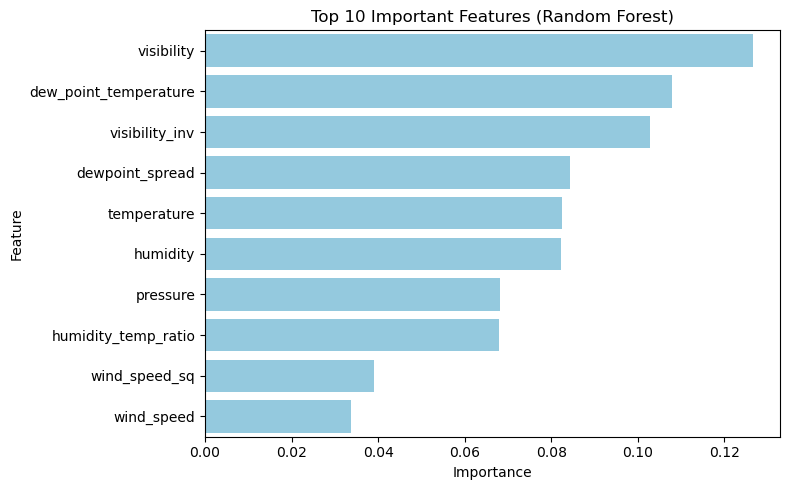

In [12]:
# Evaluate feature importance directly from a trained Random Forest model.

# Train a Random Forest on the same data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extract and sort feature importance
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(rf_importances.head(10))

# Visualize importance
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=rf_importances.head(10), color='skyblue')
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


The Random Forest model identified visibility, dew point temperature, dew point spread, and humidity as the most influential factors for predicting rainfall. Visibility and its inverse had the highest importance scores, reflecting that reduced visibility is a strong indicator of rainy conditions. Dew point–related features (dew point temperature and spread) also ranked highly, suggesting that air saturation plays a key role in rainfall formation. The consistency between the Random Forest results and the ANOVA F-test confirms that the model effectively captured the true meteorological relationships within the dataset.

### 2.3 Summary
Both statistical and model-based feature selection methods yielded consistent results.
Features related to air moisture, visibility, and atmospheric pressure—such as humidity, visibility, dew point temperature, dew point spread, and pressure—were identified as the most relevant predictors of rainfall.
These consistent findings confirm the reliability of the selected variables, which will be used in the following model training stage to enhance prediction accuracy and interpretability.

## 3. Model Training and Evaluation - Supervised Learning

Two supervised learning algorithms were selected for this project: Logistic Regression and Random Forest.

Logistic Regression was chosen as a baseline linear model because it is simple, interpretable, and well-suited for binary classification tasks such as predicting whether it will rain (is_rain = 0/1). It provides clear insight into the contribution and direction of each meteorological feature (e.g., humidity, visibility, pressure) to the probability of rainfall.

Random Forest was chosen as a non-linear ensemble model capable of capturing complex relationships and interactions among weather variables that a linear model might miss. By combining multiple decision trees, it reduces variance and improves predictive accuracy while maintaining robustness against noise and outliers.

### 3.1 Logistic Regression Model

Logistic Regression 5-Fold ROC-AUC: 0.907 ± 0.003
----- Logistic Regression — Classification Report ------
              precision    recall  f1-score   support

           0      0.872     0.815     0.843      1596
           1      0.826     0.881     0.853      1596

    accuracy                          0.848      3192
   macro avg      0.849     0.848     0.848      3192
weighted avg      0.849     0.848     0.848      3192

ROC-AUC: 0.914733575794122
Confusion Matrix:
 [[1300  296]
 [ 190 1406]]


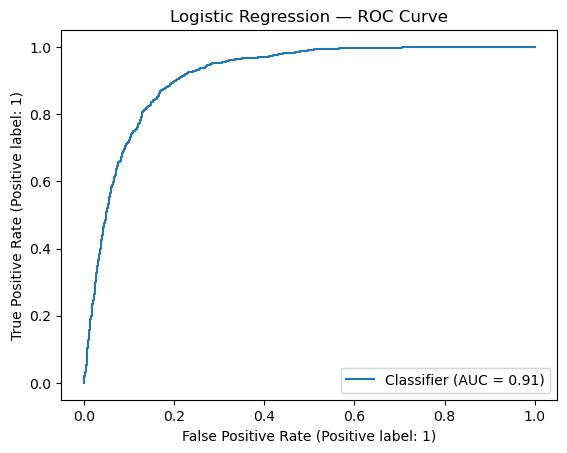

In [13]:
# Prepare features and target for supervised learning according to the results from feature selection.
selected_features = [
    'humidity',
    'humidity_temp_ratio',
    'visibility',
    'dew_point_temperature',
    'dewpoint_spread',
    'pressure',
    'temperature',
    'wind_speed',
    'season_2',
    'season_3',
    'season_4'
]

# Split features and target again
X = df_balanced[selected_features].copy()
y = df_balanced["is_rain"].astype(int)

# Stratified 80/20 split to maintain class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize model with L2 regularization (default)
logreg = LogisticRegression(max_iter=2000, n_jobs=-1)

# 5-fold cross-validation for ROC-AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(logreg, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"Logistic Regression 5-Fold ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

# Fit on the full training set
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

# Performance metrics
print("----- Logistic Regression — Classification Report ------")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("Logistic Regression — ROC Curve")
plt.show()


* The 5-fold cross-validation resulted in an average ROC-AUC of 0.907 (± 0.003), indicating that the model is both accurate and stable across different data splits.
* On the test set, the model reached an overall accuracy of 0.85, with precision = 0.83 and recall = 0.88 for the rainy class, showing that it correctly identified most rainfall cases while maintaining a low false-alarm rate.
* The ROC-AUC of 0.915 further confirms that the model can clearly distinguish between rainy and non-rainy observations.
* The confusion matrix demonstrates that false negatives (missed rainy days) are fewer than false positives, which is desirable in weather forecasting, where predicting rain when uncertain is often preferable to missing actual rain events.

### 3.2 Random Forest Classifier

Random Forest 5-Fold ROC-AUC: 0.989 ± 0.002
------- Random Forest — Classification Report --------
              precision    recall  f1-score   support

           0      0.953     0.948     0.950      1596
           1      0.948     0.953     0.951      1596

    accuracy                          0.951      3192
   macro avg      0.951     0.951     0.951      3192
weighted avg      0.951     0.951     0.951      3192

ROC-AUC: 0.9897855148522936
Confusion Matrix:
 [[1513   83]
 [  75 1521]]


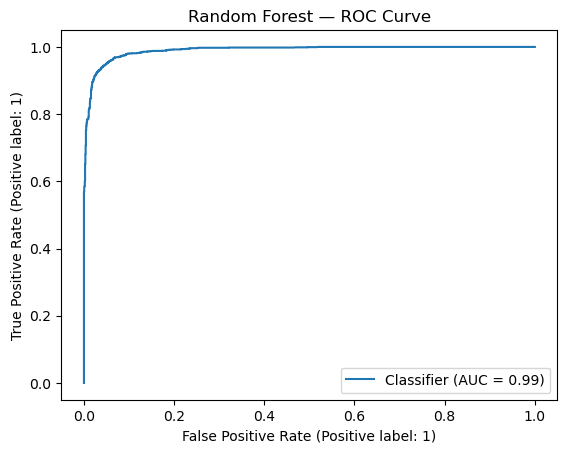

In [14]:
# Initialize model with moderate regularization to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=None,         # let trees grow fully
    min_samples_split=4,    # prevent over-complex trees
    min_samples_leaf=2,     # control leaf size
    random_state=42,
    n_jobs=-1
)

# Cross-validation ROC-AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"Random Forest 5-Fold ROC-AUC: {cv_auc_rf.mean():.3f} ± {cv_auc_rf.std():.3f}")

# Fit on training data
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Performance metrics
print("------- Random Forest — Classification Report --------")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("Random Forest — ROC Curve")
plt.show()


* The 5-fold cross-validation produced an average ROC-AUC of 0.989 (± 0.002), showing extremely stable and consistent model behavior across different folds.
* On the test set, the model obtained an overall accuracy of 0.95, with both precision = 0.95 and recall = 0.95 for the rainy and non-rainy classes.
* This balanced result indicates that the model rarely misses actual rain events (low false negatives) while maintaining a very low false-alarm rate.
* The ROC curve (AUC = 0.99) confirms that Random Forest almost perfectly separates rainy from non-rainy conditions.
* Compared with the Logistic Regression baseline, the Random Forest model shows a substantial improvement in all metrics, demonstrating its ability to capture complex non-linear interactions among meteorological variables such as visibility, humidity, dew-point temperature, and pressure.

### 3.3 Overfitting and Underfitting Avoidance
To ensure the models generalize well and do not suffer from overfitting or underfitting, several strategies were applied.

A stratified 5-fold cross-validation was used to evaluate model stability and performance across different data splits.
Regularization (L2 penalty) in the Logistic Regression model prevented coefficients from becoming too large, reducing overfitting.

For the Random Forest model, hyperparameter tuning was applied by controlling model complexity using min_samples_split, min_samples_leaf, and a sufficient number of trees (n_estimators = 300) to balance bias and variance.

These techniques collectively ensured that the models achieved high accuracy while maintaining good generalization to unseen data.

Overfitting is avoided through cross-validation and limiting tree depth / regularisation parameters.

### 3.4 Model Comparison

In [15]:
def summarize_model(name, y_test, y_pred, y_prob):
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

summary = []
summary.append(summarize_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr))
summary.append(summarize_model("Random Forest", y_test, y_pred_rf, y_prob_rf))

pd.DataFrame(summary).round(3)


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Logistic Regression,0.848,0.826,0.881,0.853,0.915
1,Random Forest,0.951,0.948,0.953,0.951,0.990


The performance comparison between Logistic Regression and Random Forest shows that both models achieved high accuracy and balanced classification, but Random Forest significantly outperformed the linear baseline across all metrics.

Logistic Regression achieved an accuracy of 0.85 and ROC-AUC of 0.91, providing a solid and interpretable baseline.

However, the Random Forest model reached an accuracy of 0.95 and ROC-AUC of 0.99, demonstrating superior predictive capability and better generalization.

The ensemble nature of Random Forest allowed it to capture complex non-linear interactions between meteorological variables such as humidity, visibility, dew point temperature, and pressure, which a linear model could not represent.

Therefore, Random Forest was selected as the final model for rainfall classification due to its higher accuracy, robustness, and ability to generalize without overfitting.

## 4. Explainable AI (XAI)

### 4.1 Permutation Importance

,feature,perm_importance_mean,perm_importance_std
0,visibility,0.212716,0.006343
1,dew_point_temperature,0.103789,0.004205
2,pressure,0.075849,0.004056
3,temperature,0.070251,0.002701
4,wind_speed,0.040134,0.002583
5,humidity,0.011348,0.002089
6,season_3,0.008145,0.001469
7,dewpoint_spread,0.006425,0.001132
8,humidity_temp_ratio,0.005453,0.001902
9,season_2,0.003415,0.000721


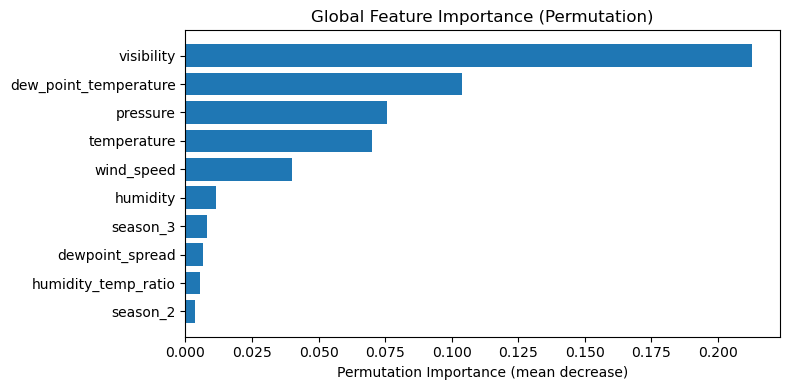

In [16]:
# Retrieve permutation importance from the trained Random Forest model.
feature_names = np.array(selected_features)
r = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring="f1_weighted"
)

# Extract mean and std of importances
imp_mean = r.importances_mean
imp_std  = r.importances_std
# Sort features by mean importance
order = np.argsort(imp_mean)[::-1]

# Create a DataFrame for better visualization
imp_df = pd.DataFrame({
    "feature": feature_names[order],
    "perm_importance_mean": imp_mean[order],
    "perm_importance_std": imp_std[order]
})
display(imp_df.head(10))

# Visualize the top 10 features
top_k = min(10, len(feature_names))
plt.figure(figsize=(8, max(4, 0.35*top_k)))
plt.barh(imp_df["feature"].head(top_k)[::-1], imp_df["perm_importance_mean"].head(top_k)[::-1])
plt.xlabel("Permutation Importance (mean decrease)")
plt.title("Global Feature Importance (Permutation)")
plt.tight_layout()
plt.show()


To interpret the Random Forest model, permutation importance was applied to evaluate the global contribution of each feature.
This method measures how much the model’s F1-weighted score decreases when a specific feature is randomly shuffled, providing a model-agnostic indicator of real predictive influence.

As shown in the Figure, visibility, dew point temperature, pressure, temperature, and wind speed produced the largest performance drops, indicating that these variables have the strongest influence on the model’s predictions.
In contrast, features such as season 2–4 and humidity temperature ratio showed only minor effects.

These findings suggest that atmospheric visibility and dew-point conditions are the most critical factors for accurately forecasting the target variable, while seasonal indicators play a secondary role.
The results also confirm that the model relies on physically meaningful meteorological variables rather than random noise, demonstrating good interpretability.

### 4.2 SHAP TreeExplainer

SHAP is used to interpret the model and visualise how each feature contributes to predictions. It helps understand the model’s decision process.

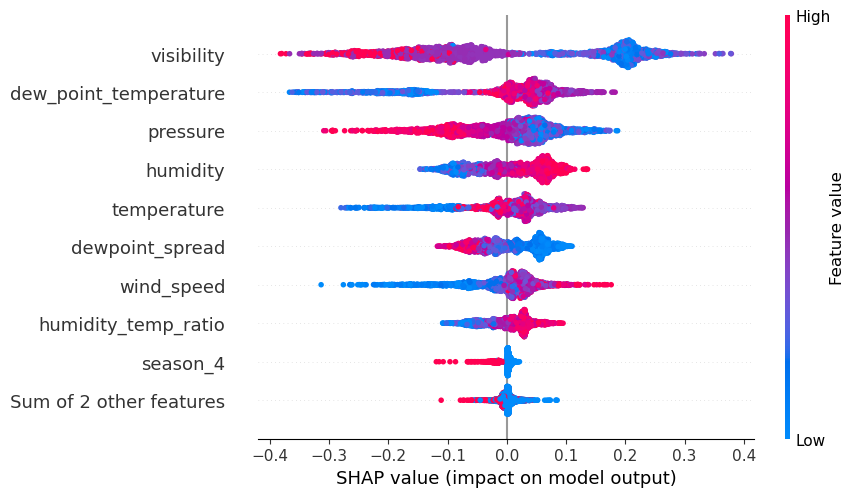

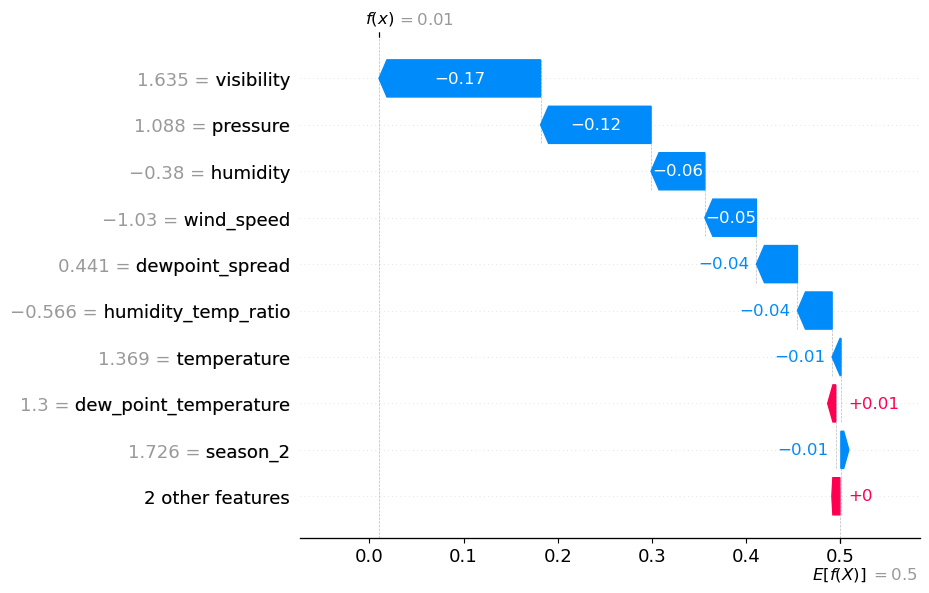

In [ ]:
# Get SHAP values from the trained Random Forest model.
X_test_rf = X_test[rf.feature_names_in_] if hasattr(rf, "feature_names_in_") else X_test

shap.initjs()

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf)
exp_all = explainer(X_test_rf)              # shape: (n_samples, n_features, n_classes)

# For binary classification, take SHAP values for the positive class
exp_pos = exp_all[..., 1]                   # shape: (n_samples, n_features)

# Global (summary) plot
shap.plots.beeswarm(exp_pos, max_display=10)

# Local (waterfall for the i-th instance)
i = 0
shap.plots.waterfall(exp_pos[i], max_display=10)


The SHAP summary plot reveals that visibility, dew point temperature, and pressure are the three most influential features affecting the Random Forest predictions.
In general, higher visibility values reduce the predicted probability of a positive outcome, while higher dew point temperature and pressure increase it.
This implies that the model relies primarily on meteorological variables that describe atmospheric clarity and air moisture conditions.

Other features such as humidity, temperature, and wind speed also contribute moderately, whereas seasonal variables and humidity-temperature ratio have relatively minor effects.
The overall pattern indicates that the model’s reasoning aligns with realistic weather dynamics, demonstrating good interpretability.

The waterfall plot provides a detailed breakdown of how each feature contributed to the prediction for a single test instance.
In this example, high visibility and pressure strongly decreased the predicted probability, while a higher dew point temperature slightly increased it.

Other factors such as humidity and wind speed exerted smaller negative effects.
The overall contribution leads the model to predict a low probability of rainfall for this sample, which is meteorologically reasonable.

Through SHAP TreeExplainer, both global and local analyses confirmed that the Random Forest model’s predictions are mainly driven by physically meaningful weather features.
The consistency between statistical importance and meteorological reasoning suggests that the model is interpretable and not overfitted to random noise.